1) IMPORTING THE LIBRARIES

In [172]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsforecast import StatsForecast
from statsforecast.models import Naive
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU, SimpleRNN




2) Load and Preprocess Dataset


In [173]:
df=pd.read_csv("SPX.csv")
df = df.dropna() 
df = df[(df != 0).all(axis=1)] 
len(df)

2515

3. Datetime Indexing


In [174]:
df = pd.read_csv('SPX.csv', index_col='Date', parse_dates=True)
df.head()

,Close/Last,Open,High,Low
Date,,,,
2015-03-24,2091.50,2103.94,2107.63,2091.50
2015-03-25,2061.05,2093.10,2097.43,2061.05
2015-03-26,2056.15,2059.94,2067.15,2045.50
2015-03-27,2061.02,2055.78,2062.83,2052.96
2015-03-30,2086.24,2064.11,2088.97,2064.11


In [175]:
print(df.columns)


Index(['Close/Last', 'Open', 'High', 'Low'], dtype='object')


In [176]:
df.index

DatetimeIndex(['2015-03-24', '2015-03-25', '2015-03-26', '2015-03-27',
               '2015-03-30', '2015-03-31', '2015-04-01', '2015-04-02',
               '2015-04-03', '2015-04-06',
               ...
               '2025-03-10', '2025-03-11', '2025-03-12', '2025-03-13',
               '2025-03-14', '2025-03-17', '2025-03-18', '2025-03-19',
               '2025-03-20', '2025-03-21'],
              dtype='datetime64[ns]', name='Date', length=2521, freq=None)

To get the closing price


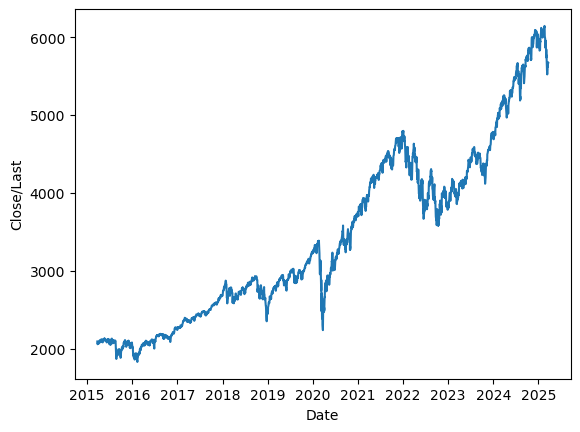

In [177]:
sns.lineplot(df, x='Date', y='Close/Last')
plt.show()

Sampling the data

<Axes: xlabel='Date'>

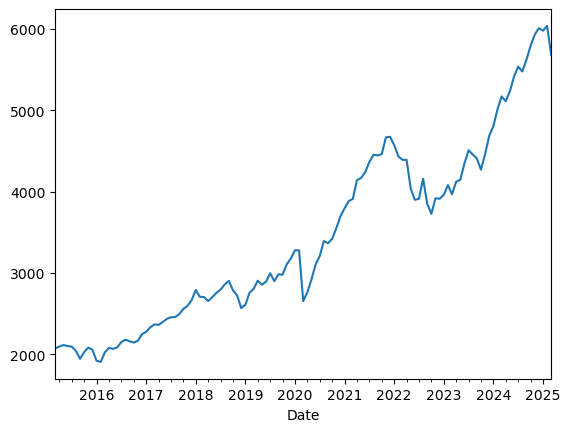

In [178]:
df.resample(rule='ME')["Close/Last"].mean().plot()


Trend component of Close/Last

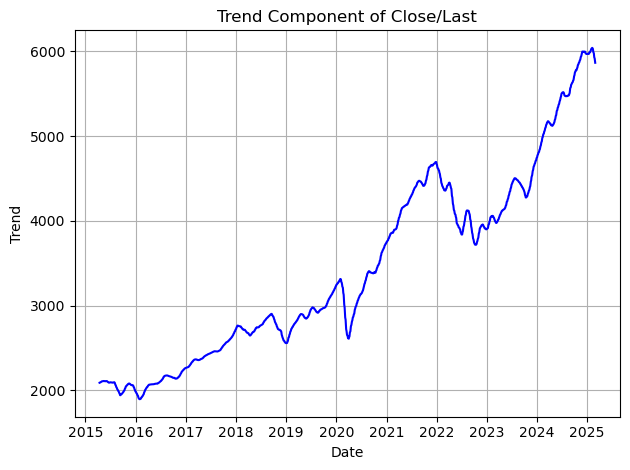

In [179]:
df.sort_index(inplace=True)
result = seasonal_decompose(df['Close/Last'], model='additive', period=30)  
plt.plot(result.trend, color='blue')
plt.title('Trend Component of Close/Last')
plt.xlabel('Date')
plt.ylabel('Trend')
plt.grid(True)
plt.tight_layout()
plt.show()


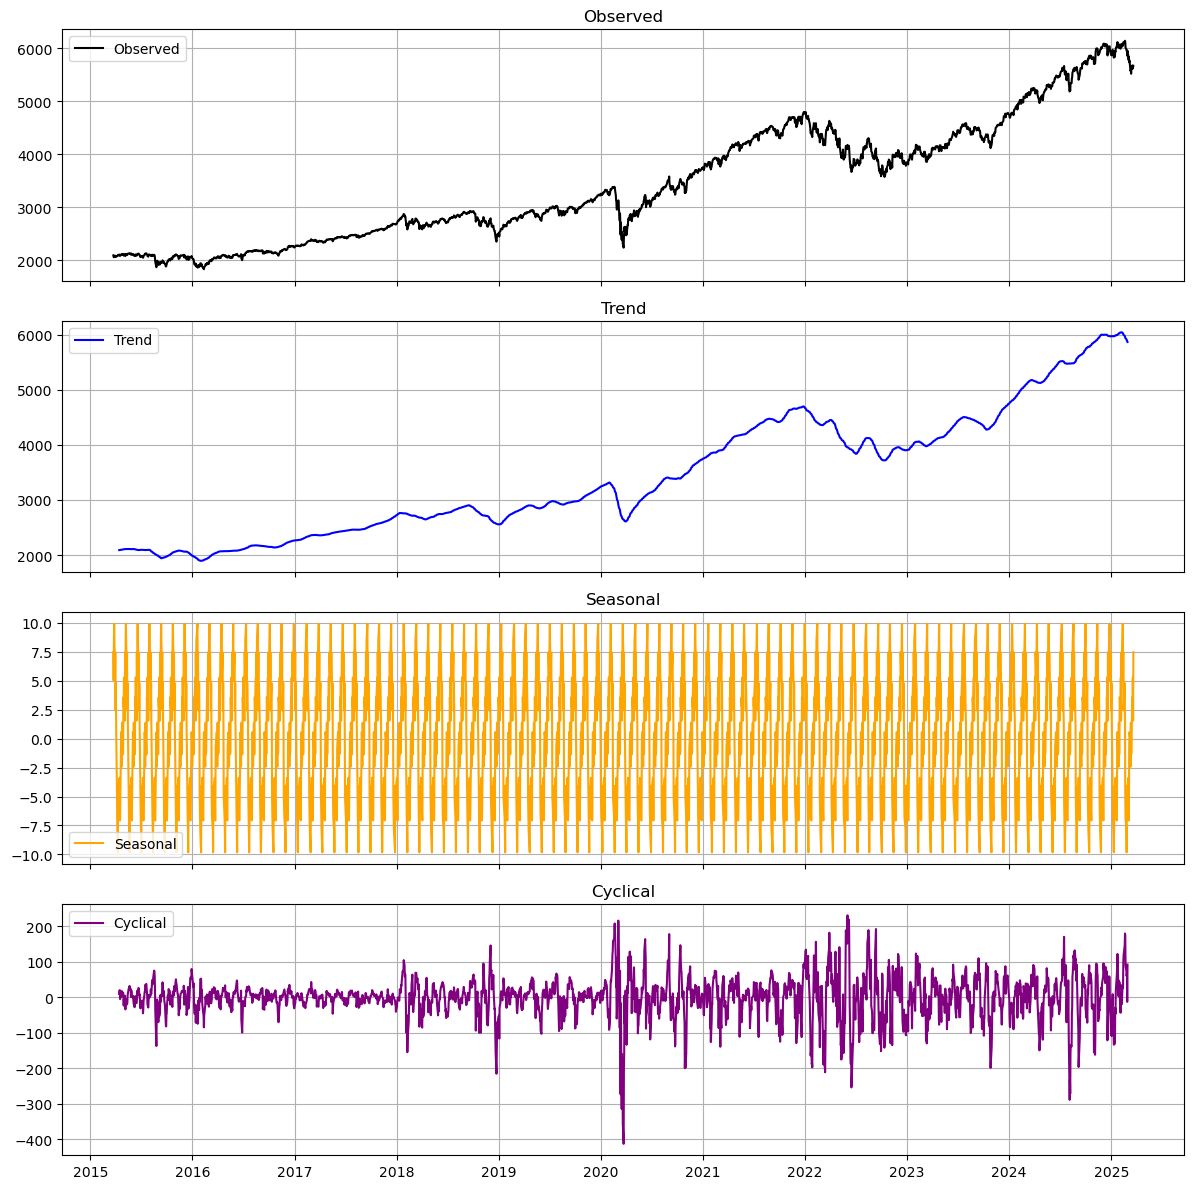

In [180]:
result = seasonal_decompose(df['Close/Last'], model='additive', period=30)
cyclical = df['Close/Last'] - result.trend - result.seasonal
fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

axes[0].plot(df['Close/Last'], label='Observed', color='black')
axes[0].set_title('Observed')

axes[1].plot(result.trend, label='Trend', color='blue')
axes[1].set_title('Trend')

axes[2].plot(result.seasonal, label='Seasonal', color='orange')
axes[2].set_title('Seasonal')

axes[3].plot(cyclical, label='Cyclical', color='purple')
axes[3].set_title('Cyclical')

for ax in axes:
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


Train -test-split(for classical models)


In [181]:
split_date = '2023-04-21'
df['split'] = np.where(df.index < split_date, 'train', 'test')
df['id'] = 0
train_data = df[df['split']=='train'].drop('split', axis=1).copy()
test_data = df[df['split']=='test'].drop('split', axis=1).copy()


In [182]:
train_data.head()

,Close/Last,Open,High,Low,id
Date,,,,,
2015-03-24,2091.50,2103.94,2107.63,2091.50,0
2015-03-25,2061.05,2093.10,2097.43,2061.05,0
2015-03-26,2056.15,2059.94,2067.15,2045.50,0
2015-03-27,2061.02,2055.78,2062.83,2052.96,0
2015-03-30,2086.24,2064.11,2088.97,2064.11,0


In [183]:
test_data.head()

,Close/Last,Open,High,Low,id
Date,,,,,
2023-04-21,4133.52,4132.14,4138.02,4113.86,0
2023-04-24,4137.04,4132.07,4142.41,4117.77,0
2023-04-25,4071.63,4126.43,4126.43,4071.38,0
2023-04-26,4055.99,4087.78,4089.67,4049.35,0
2023-04-27,4135.35,4075.29,4138.24,4075.29,0


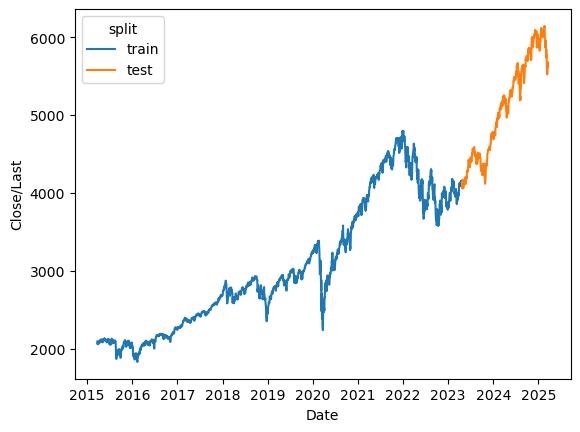

In [184]:
sns.lineplot(df, x='Date', y='Close/Last', hue='split')
plt.show()

Classical Models

In [185]:
from statsforecast.core import StatsForecast
from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from statsforecast.models import (
    Naive,
    SeasonalNaive,
    SimpleExponentialSmoothing,
    Holt,
    HoltWinters,
    AutoARIMA,
    ARIMA
)

In [186]:
test_data = test_data.reset_index()
test_data = test_data.rename(columns={'Close/Last': 'Close'})
test_data['Date'] = pd.to_datetime(test_data['Date'])
test_data['id'] = '0'

In [187]:
import pandas as pd
df=pd.read_csv('SPX.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df_resampled = df.resample('MS', on='Date').last().reset_index()
df_resampled = df_resampled.rename(columns={'Date': 'Month'})
df_resampled['id'] = 0
df_resampled.head()


,Month,Close/Last,Open,High,Low,id
0,2015-03-01,2067.89,2084.05,2084.05,2067.04,0
1,2015-04-01,2085.51,2105.52,2105.52,2077.59,0
2,2015-05-01,2107.39,2120.66,2120.66,2104.89,0
3,2015-06-01,2063.11,2061.19,2074.28,2056.32,0
4,2015-07-01,2103.84,2111.60,2114.24,2102.07,0


In [188]:
split_date = '2023-04-01'
train_data = df_resampled[df_resampled['Month'] < split_date].copy()
test_data = df_resampled[df_resampled['Month'] >= split_date].copy()


Naive Forecasting

In [189]:
sf = StatsForecast(
    models=[Naive()],
    freq='MS',
    n_jobs=-1
)
sf.fit(df=train_data,
       id_col='id',
       time_col='Month',
       target_col='Close/Last',
       )
y_pred_all = sf.predict(h=len(test_data))

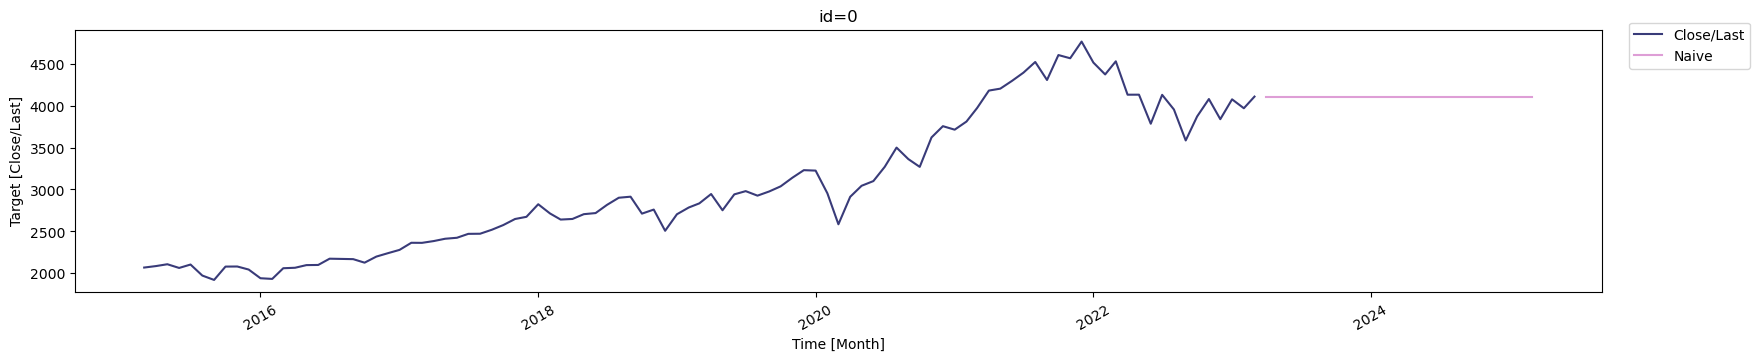

In [190]:
sf.plot(train_data,
        y_pred_all,
        id_col='id',
        time_col='Month',
        target_col='Close/Last',
        )

Evaluation Metrics for Naive Forecast

In [191]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
y_true = test_data['Close/Last'].values
y_pred = y_pred_all['Naive'].values 

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mse)


print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MSE: 1421789.96
MAE: 1011.56
RMSE: 1192.39


Seasonal Naive 

In [192]:
sf = StatsForecast(
    models=[SeasonalNaive(season_length=12)],
    freq='MS',
    n_jobs=-1
)
sf.fit(df= train_data,
       id_col='id',
       time_col='Month',
       target_col='Close/Last',
       )
y_pred_all = sf.predict(h=len(test_data))

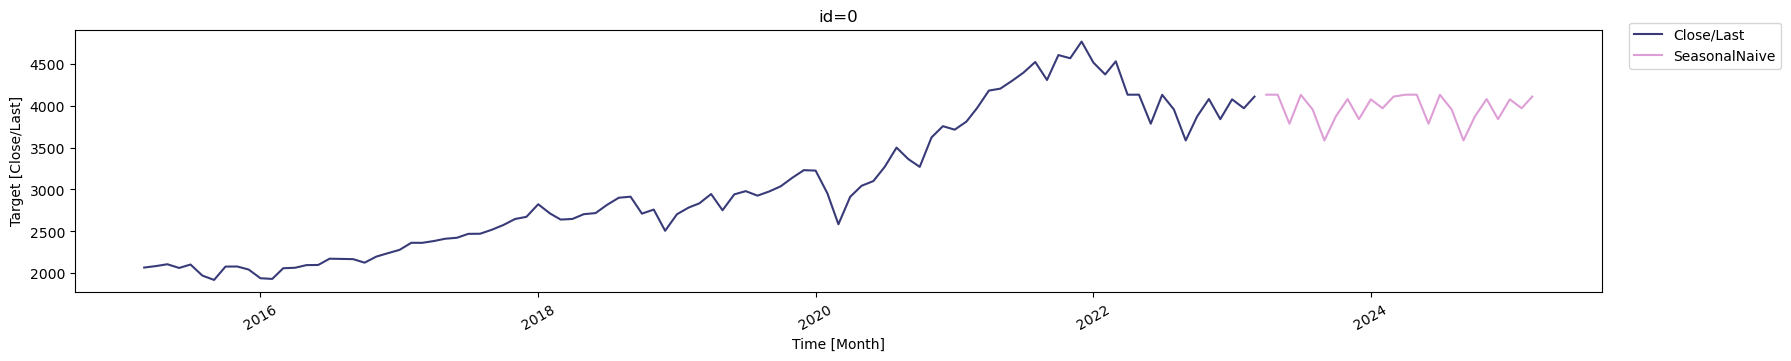

In [193]:
sf.plot(train_data,
        y_pred_all,
        id_col='id',
        time_col='Month',
        target_col='Close/Last',
        )

Evaluation Metrics For Seasonal Naive

In [194]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_true = test_data['Close/Last'].values
y_pred = y_pred_all['SeasonalNaive'].values 
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:.2f}")
print(f" MSE: {mse:.2f}")
print(f" MAE: {mae:.2f}")


RMSE: 1320.94
 MSE: 1744893.03
 MAE: 1148.54


Holt,HoltWinter,SES

In [195]:
sf = StatsForecast(
    models=[SimpleExponentialSmoothing(alpha=2/(12+1)),
            Holt(error_type='A', season_length=12),
            HoltWinters(error_type='A', season_length=12)],
    freq='MS',
    n_jobs=-1
)
sf.fit(df=train_data,
       id_col='id',
       time_col='Month',
       target_col='Close/Last',
       )
y_pred_all = sf.predict(h=len(test_data))

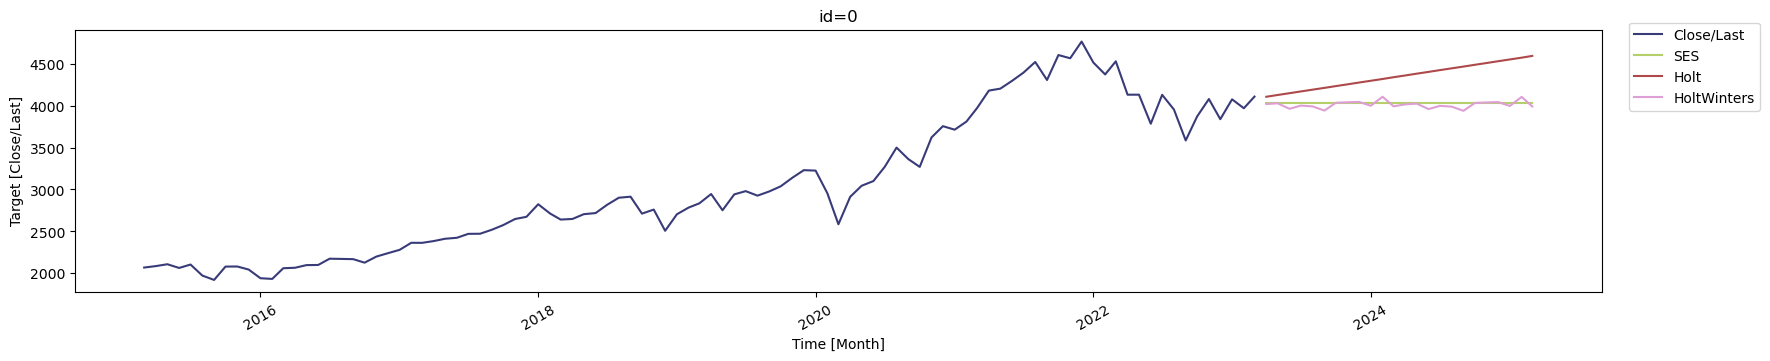

In [196]:
sf.plot(train_data,
        y_pred_all,
        id_col='id',
        time_col='Month',
        target_col='Close/Last',
        )

In [197]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
y_true = test_data['Close/Last'].values
for model_name in y_pred_all.columns[2:]:  
    y_pred = y_pred_all[model_name].values
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE: {rmse:.2f}")
    print(f"{model_name} -> MSE: {mse:.2f}, MAE: {mae:.2f}")


RMSE: 1258.79
SES -> MSE: 1584544.92, MAE: 1089.04
RMSE: 913.69
Holt -> MSE: 834832.40, MAE: 773.00
RMSE: 1273.49
HoltWinters -> MSE: 1621769.98, MAE: 1107.80


Augmented Dickey-Fuller test.

In [198]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df_monthly['Close'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key}: {value}")

if result[1] <= 0.05:
    print("The series is stationary (reject null hypothesis).")
else:
    print("The series is non-stationary (fail to reject null hypothesis).")


ADF Statistic: 0.4416027830708959
p-value: 0.9829858146357323
Critical Values:
   1%: -3.486055829282407
   5%: -2.8859430324074076
   10%: -2.5797850694444446
The series is non-stationary (fail to reject null hypothesis).


First Order Differencing


 ADF Test on First-Differenced Series
ADF Statistic: -8.673210158827453
p-value: 4.4878995737399064e-14
   1%: -3.5019123847798657
   5%: -2.892815255482889
   10%: -2.583453861475781
 Stationary


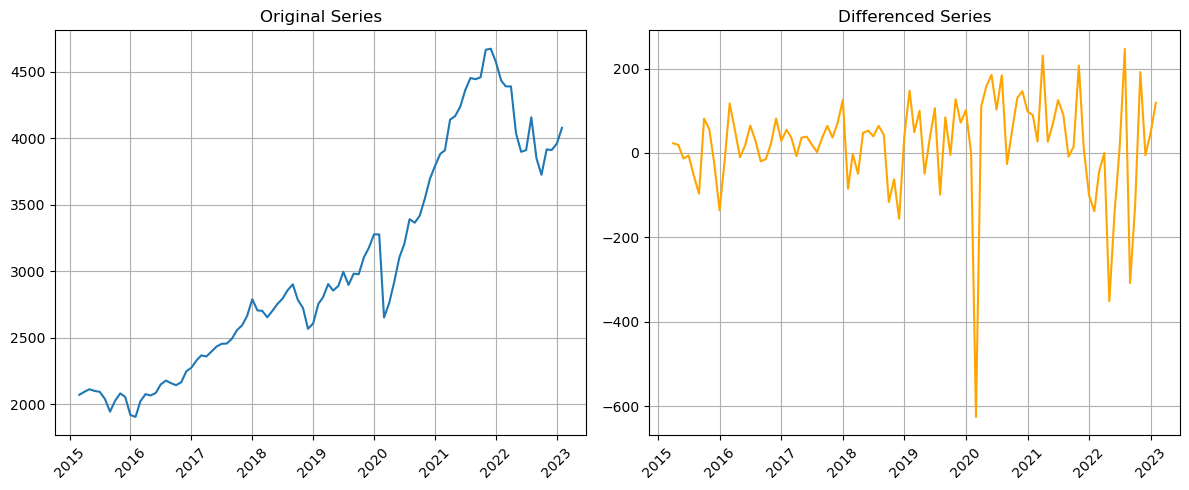

In [199]:
df = pd.read_csv("SPX.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df_monthly = df.resample('MS', on='Date').mean().reset_index()
df_monthly = df_monthly[['Date', 'Close/Last']]
df_monthly.columns = ['Month', 'Close']

train_size = int(len(df_monthly) * 0.8)
train = df_monthly.iloc[:train_size].copy()
train['Close_diff'] = train['Close'].diff().dropna()

print("\n ADF Test on First-Differenced Series")
result_diff = adfuller(train['Close_diff'].dropna())
print("ADF Statistic:", result_diff[0])
print("p-value:", result_diff[1])
for key, value in result_diff[4].items():
    print(f"   {key}: {value}")
print(" Stationary" if result_diff[1] <= 0.05 else " Non-Stationary")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train['Month'], train['Close'], label='Original')
plt.title('Original Series')
plt.xticks(rotation=45)
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train['Month'], train['Close_diff'], label='1st Difference', color='orange')
plt.title('Differenced Series')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()


Arima,AutoArima

In [200]:
arima_model = ARIMA(order=(2, 1, 1),
                    seasonal_order=(1, 1, 1), 
                    season_length=12)
auto_arima_model = AutoARIMA(
    max_p=2, max_d=1, max_q=2, max_P=2, max_D=1, max_Q=2, stepwise=True, season_length=12)

In [201]:
from statsforecast.models import AutoARIMA
auto_arima_model = AutoARIMA(season_length=12)


In [202]:
import pandas as pd
import numpy as np
from statsforecast import StatsForecast
from statsforecast.models import ARIMA, AutoARIMA

df = pd.read_csv('SPX.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

df_monthly = df.resample('MS', on='Date').mean().reset_index()

df_monthly = df_monthly[['Date', 'Close/Last']]
df_monthly.columns = ['Month', 'Close/Last']

df_monthly['id'] = 0

split_date = '2023-04-01'
train_data = df_monthly[df_monthly['Month'] < split_date].copy()
test_data = df_monthly[df_monthly['Month'] >= split_date].copy()

arima_model = ARIMA(order=(3,2,4))
auto_arima_model = AutoARIMA()

sf = StatsForecast(
    models=[arima_model, auto_arima_model],
    freq='MS',
    n_jobs=-1
)

sf.fit(df=train_data, id_col='id', time_col='Month', target_col='Close/Last')

y_pred_all = sf.predict(h=len(test_data))

print(y_pred_all.head())


   id      Month        ARIMA    AutoARIMA
0   0 2023-04-01  4006.848614  3988.329104
1   0 2023-05-01  4356.816765  4008.099078
2   0 2023-06-01  4272.395564  4027.869051
3   0 2023-07-01  4083.030775  4047.639025
4   0 2023-08-01  4268.727510  4067.408998


In [203]:
sf = StatsForecast(
    models=[arima_model,
            auto_arima_model],
    freq='MS',
    n_jobs=-1
)
sf.fit(df=train_data,
       id_col='id',
       time_col='Month',
       target_col='Close/Last',
       )
y_pred_all = sf.predict(h=len(test_data))

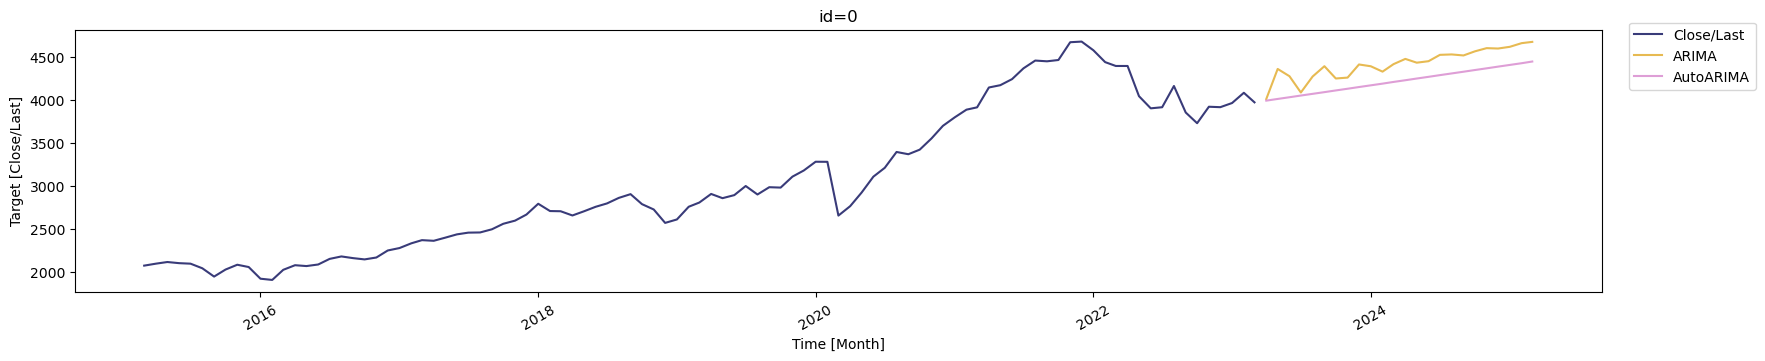

In [204]:
sf.plot(train_data,
        y_pred_all,
        id_col='id',
        time_col='Month',
        target_col='Close/Last',
        )

Evaluation Metrics for Arima , AutoArima

In [205]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_true = test_data['Close/Last'].values

for model_name in y_pred_all.columns[2:]:   
    y_pred = y_pred_all[model_name].values

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE: {rmse:.2f}")


    print(f"{model_name} -> MSE: {mse:.2f}, MAE: {mae:.2f}")


RMSE: 838.45
ARIMA -> MSE: 702996.48, MAE: 692.69
RMSE: 1012.33
AutoARIMA -> MSE: 1024816.83, MAE: 876.91


SArima and its Evaluation Metrics

In [206]:
train_size = int(len(df_monthly) * 0.8)
train = df_monthly.iloc[:train_size]
test = df_monthly.iloc[train_size:].copy()


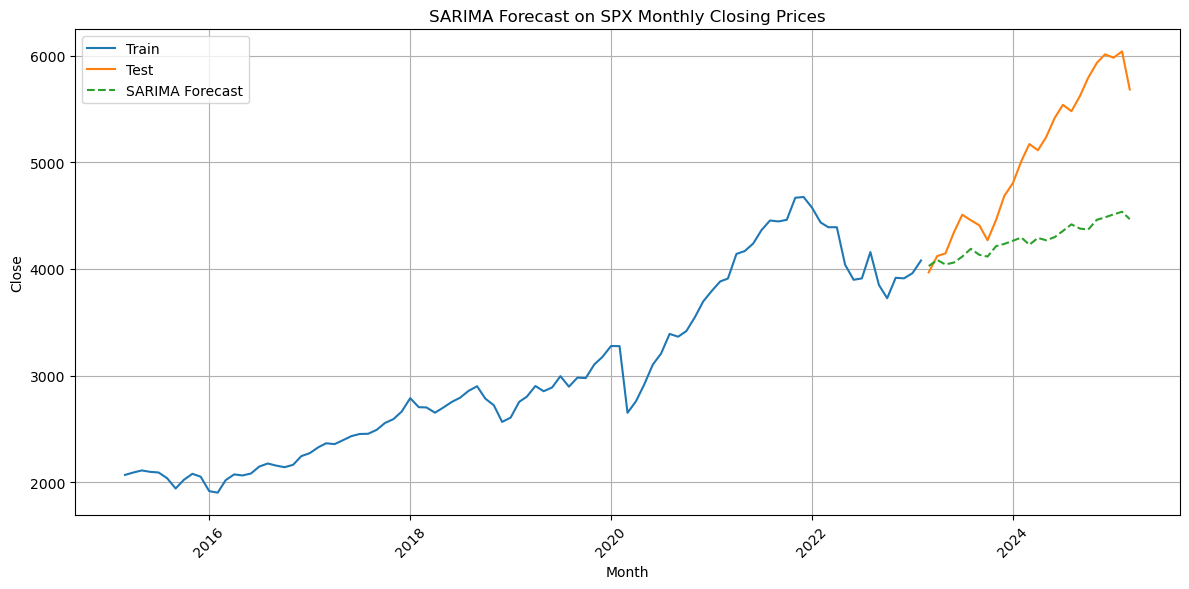

MSE:  868043.04
RMSE: 931.69
MAE:  778.50


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings


train_size = int(len(df_monthly) * 0.8)
train = df_monthly.iloc[:train_size]
test = df_monthly.iloc[train_size:].copy()

sarima_model = SARIMAX(train['Close/Last'], 
                       order=(2,1,1), 
                       seasonal_order=(1,1,1,12), 
                       enforce_stationarity=False, 
                       enforce_invertibility=False)
sarima_result = sarima_model.fit(disp=False)

sarima_forecast = sarima_result.forecast(steps=len(test))
test['SARIMA Forecast'] = sarima_forecast.values

plt.figure(figsize=(12,6))
sns.lineplot(data=train, x='Month', y='Close/Last', label='Train')
sns.lineplot(data=test, x='Month', y='Close/Last', label='Test')
sns.lineplot(data=test, x='Month', y='SARIMA Forecast', label='SARIMA Forecast', linestyle='--')
plt.title('SARIMA Forecast on SPX Monthly Closing Prices')
plt.xlabel('Month')
plt.ylabel('Close')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

y_true = test['Close/Last'].values
y_pred = test['SARIMA Forecast'].values

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mse)

print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")


ACF,PACF

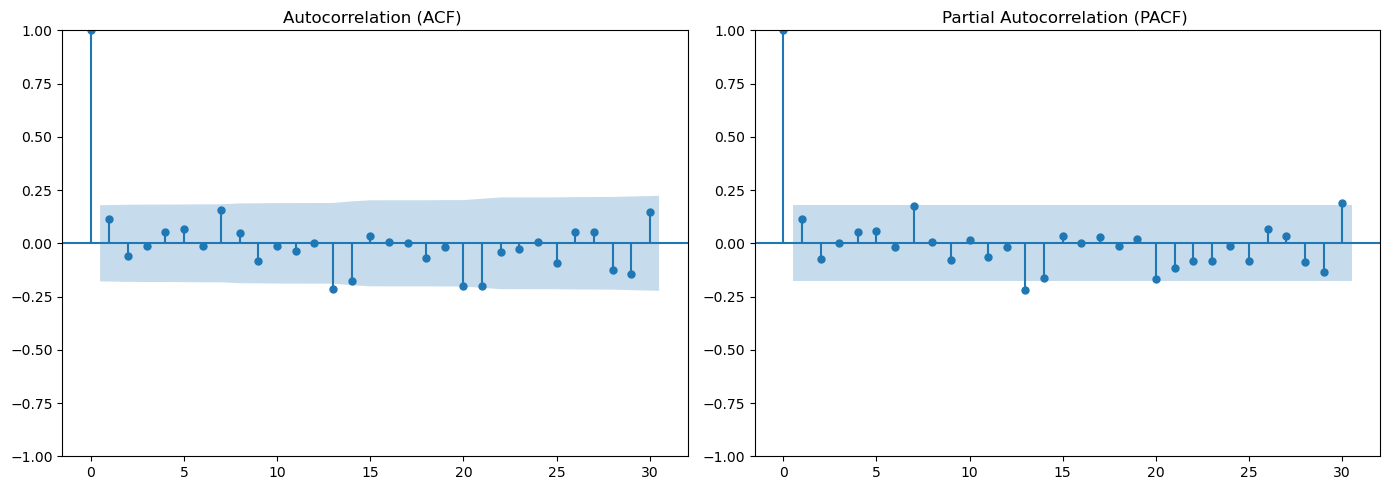

In [208]:
df = pd.read_csv("SPX.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

df_monthly = df.resample('MS', on='Date').mean().reset_index()
df_monthly = df_monthly[['Date', 'Close/Last']]
df_monthly.columns = ['Month', 'Close']

df_monthly['Close_diff'] = df_monthly['Close'].diff().dropna()

diff_series = df_monthly['Close_diff'].dropna()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(diff_series, lags=30, ax=axes[0])
axes[0].set_title('Autocorrelation (ACF) ')

plot_pacf(diff_series, lags=30, ax=axes[1], method='ywm')
axes[1].set_title('Partial Autocorrelation (PACF) ')

plt.tight_layout()
plt.show()


XGBOOST(ADVANCED MACHINE LEARNING MODELS) AND ITS EVALUATION METRICS

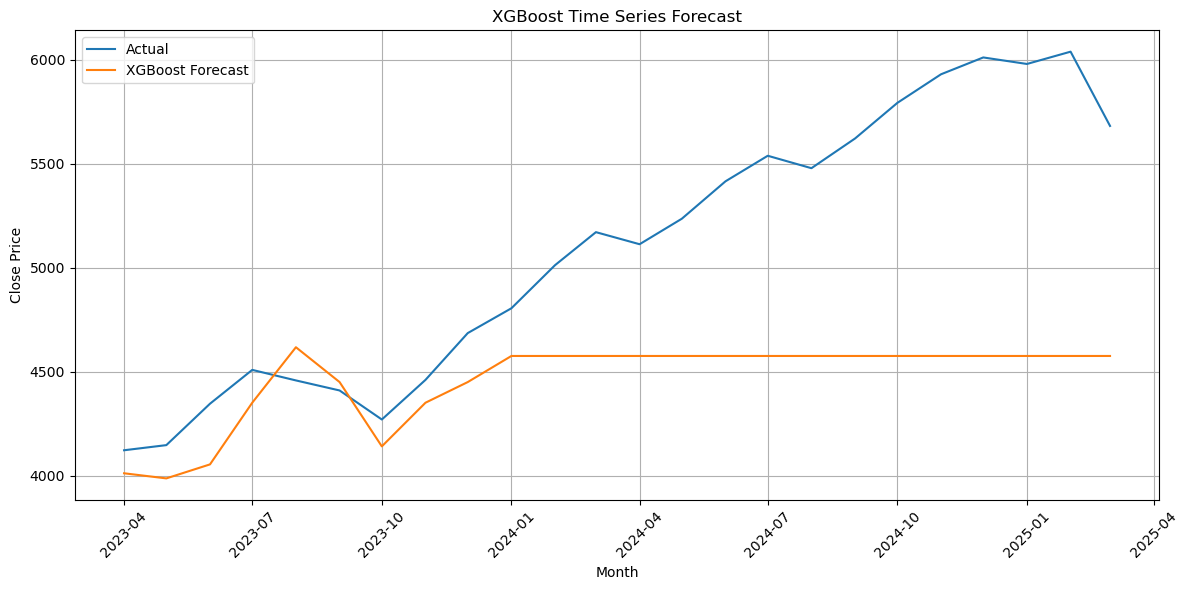

RMSE: 812.51
MSE: 660167.54
MAE: 649.58


In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

df = pd.read_csv('SPX.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

df_monthly = df.resample('MS', on='Date').mean().reset_index()
df_monthly = df_monthly[['Date', 'Close/Last']]
df_monthly.columns = ['Month', 'Close']


df_monthly['Lag1'] = df_monthly['Close'].shift(1)

df_model = df_monthly.dropna().reset_index(drop=True)

X = df_model['Lag1'].values.reshape(-1, 1)   
y = df_model['Close'].values

train_size = int(len(df_model) * 0.8)
X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

test_dates = df_model['Month'].iloc[train_size:]

model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

plt.figure(figsize=(12, 6))
sns.lineplot(x=test_dates, y=y_test, label='Actual')
sns.lineplot(x=test_dates, y=y_pred, label='XGBoost Forecast')
plt.title("XGBoost Time Series Forecast")
plt.xlabel("Month")
plt.ylabel("Close Price")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:.2f}")
print(f'MSE: {mse:.2f}')
print(f'MAE: {mae:.2f}')


LSTM AND ITS EVALUATION METRICS

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
R2: 0.5079, MSE: 173518.15, RMSE: 416.56, MAE: 378.62


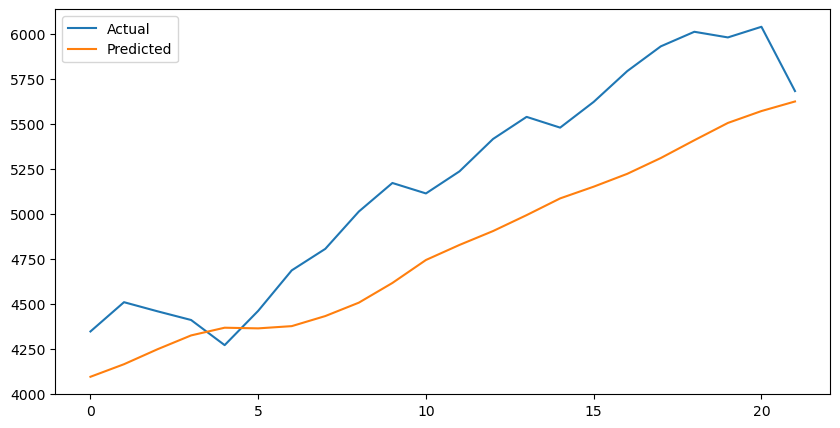

In [210]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU, SimpleRNN
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

df = pd.read_csv('SPX.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df_monthly = df.resample('MS', on='Date').mean().reset_index()
df_monthly = df_monthly[['Date', 'Close/Last']]
df_monthly.columns = ['Date', 'Close']

scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(df_monthly[['Close']])

SEQ_LEN = 12
X, y = [], []
for i in range(len(scaled_close) - SEQ_LEN):
    X.append(scaled_close[i:i+SEQ_LEN])
    y.append(scaled_close[i+SEQ_LEN])
X, y = np.array(X), np.array(y)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

model = Sequential([
    LSTM(50, activation='relu', input_shape=(SEQ_LEN, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=0)

y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)

mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f'R2: {r2:.4f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}')

plt.figure(figsize=(10,5))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.legend()
plt.show()


RNNS AND ITS EVALUATION METRICS

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
R2: 0.8281, MSE: 60607.16, RMSE: 246.19, MAE: 226.39


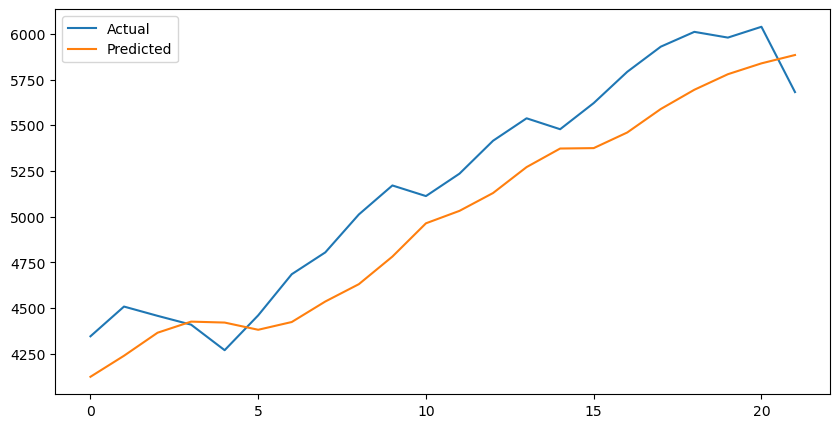

In [211]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU, SimpleRNN
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.layers import SimpleRNN


df = pd.read_csv('SPX.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df_monthly = df.resample('MS', on='Date').mean().reset_index()
df_monthly = df_monthly[['Date', 'Close/Last']]
df_monthly.columns = ['Date', 'Close']

scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(df_monthly[['Close']])

SEQ_LEN = 12
X, y = [], []
for i in range(len(scaled_close) - SEQ_LEN):
    X.append(scaled_close[i:i+SEQ_LEN])
    y.append(scaled_close[i+SEQ_LEN])
X, y = np.array(X), np.array(y)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

model = Sequential([
    SimpleRNN(50, activation='relu', input_shape=(SEQ_LEN, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=0)

y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f'R2: {r2:.4f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}')

plt.figure(figsize=(10,5))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.legend()
plt.show()


In [215]:
import pandas as pd

results = {
    'Model': [
        'Naive',
        'Seasonal Naive',
        'SES',
        'Holt',
        'HoltWinters',
        'ARIMA',
        'AutoARIMA',
        'SARIMA',
        'XGBoost',
        'LSTM',
        'RNN'
    ],
    'MSE': [
        1421789.96,
        1744893.03,
        1584544.92,
        834832.40,
        1621769.98,
        702996.48,
        1024816.83,
        868043.04,
        660167.54,
        108850.63,
        43937.76
    ],
    'RMSE': [
        1192.39,
        1320.94,
        1258.79,
        913.69,
        1273.49,
        838.45,
        1012.33,
        931.69,
        812.51,
        329.93,
        209.61
    ],
    'MAE': [
        1011.56,
        1148.54,
        1089.04,
        773.00,
        1107.80,
        692.69,
        876.91,
        778.50,
        649.58,
        302.27,
        189.74
    ]
}

summary_df = pd.DataFrame(results)

summary_df = summary_df.sort_values(by='MSE')

summary_df.reset_index(drop=True, inplace=True)

print(summary_df)


             Model         MSE     RMSE      MAE
0              RNN    43937.76   209.61   189.74
1             LSTM   108850.63   329.93   302.27
2          XGBoost   660167.54   812.51   649.58
3            ARIMA   702996.48   838.45   692.69
4             Holt   834832.40   913.69   773.00
5           SARIMA   868043.04   931.69   778.50
6        AutoARIMA  1024816.83  1012.33   876.91
7            Naive  1421789.96  1192.39  1011.56
8              SES  1584544.92  1258.79  1089.04
9      HoltWinters  1621769.98  1273.49  1107.80
10  Seasonal Naive  1744893.03  1320.94  1148.54
